In [8]:
from qiskit_utils import *

## **Database Search Algorithm**

Here our aim is to check whether a particular lookup ket say $\ket{\phi}$ exists within a set of provided set of kets say $ \mathcal{S} = \{ \ket{\psi_1}, \ket{\psi_2}, .. . ,\ket{\psi_n }  \}$, and if so then what is the index of that particular ket in $\mathcal{S}$. For example, if $\ket{\phi} = \ket{\psi_3}$ we want to know the index $3$ using a version of simultaneous SWAP tests.

In later generalisation we can try to compare two different sets , say $\mathcal{S_1}$ and $\mathcal{S_2}$ to find an estimate of the number of elements at the intersection of of two sets, and the idexto those elements too.

Note also that we want our algorithm to work even while the elements of $\mathcal{S}$ are not all orthogonal to each other, as otherwise it would be of no real to use a quantum computer in the first place.geve

### **Algorithm**

To have some quantum advantage in our implementations we assume that we can prepare an equal superposition of all the states in our base set $\mathcal{S}$ along with an ancilla specifying the index in the set, i.e a state of the form, 
$$      \ket{\mathcal{S}} \: = \: \sum_{i = 1}^n \ket{\psi_i}\ket{i}
$$
**Step 1 :** We start with a product state of the lookup ket $\ket{\phi}$ and the equal superposition state $\ket{\mathcal{S}}$, $ \ket{step_1} \:=\: \ket{\phi} \otimes \ket{\mathcal{S}}\:=\: \ket{\phi} \otimes \sum_{i = 1}^n \ket{\psi_i}\ket{i} $

**Step 2 :** We introduce an $\ket{ancilla}$ qubit initiated at the equal superpostion state $\ket{\mathtt{+}}$ ; $  \ket{step_2} \:=\: ( \ket{0} + \ket{1} ) \otimes \sum_{i} \ket{\phi}\ket{\psi_i}\ket{i} $

**Step 3:** Apply a cotrolled swap gate (`C-SWAP`) between the qubit registers, conditioned on the $\ket{ancilla}$ ; $  \ket{step_3} \:=\: \ket{0} \otimes \big( \sum_{i} \ket{\phi}\ket{\psi_i}\ket{i} \big) \:+\: \ket{1} \otimes \big( \sum_{i} \ket{\psi_i}\ket{\phi}\ket{i} \big)  $

**Step 4:** Apply another Hadamard gate to the $\ket{ancilla}$ to obtain,
$$ \ket{step_4} \:=\: \ket{0} \otimes \sum_i \big( \ket{\phi}\ket{\psi_i} + \ket{\psi_i}\ket{\phi}\ \big)\ket{i} \; + \; \ket{1} \otimes \sum_i \big( \ket{\phi}\ket{\psi_i} - \ket{\psi_i}\ket{\phi}\ \big)\ket{i} 
$$
The last step is an essential part of the algorithm, note that the state in corresponding to $\ket{1}$ in the ancilla is $\big( \ket{\phi}\ket{\psi_i} - \ket{\psi_i}\ket{\phi}\ \big)$ which is zero whenever the lookup state $\ket{\phi}$ is same as $\ket{\psi_i}$, thus the corresponding state of the index register $\ket{i}$ is annihilated. This though gives us some indication to which elements in the set $\mathcal{S}$ are equal to the lookup state $\ket{\phi}$, it is not immediatley obvious how to recover those particular indices.

If we assume that all kets in $\mathcal{S}$ as well as $\ket{\phi}$ are normalised,then the probability of measuring the state $\ket{0}$ or $\ket{1}$ in the ancilla is given by 
$$ \mathbb{P}_{\ket{0}} \propto \sum_i \big( 1 + \| \braket{\phi|\psi_i} \|^2 \big) \;\;\;  and  \;\;\; \mathbb{P}_{\ket{1}} \propto \sum_i \big( 1 - \| \braket{\phi|\psi_i} \|^2 \big) 
$$  
However given that the sum is over all of the $n$ terms, we cannot locate the particular elements for which index states $\ket{i}$ correspond to the equality, but it is obvious clear that in general it is much more probable to measure the ancilla in $\ket{0}$ state than in $\ket{1}$ state. Since it is not much of our use to have the ancilla in $\ket{0}$ we can apply an grover operator to amplify $\ket{1}$ state substantially. This is in particular helpful whenever the states in $\mathcal{S}$ are close too $\ket{\phi}$ i.e has a high $ \|\braket{\phi|\psi_i}\| $ value, as then $\mathbb{P}_{\ket{1}}$ and $\mathbb{P}_{\ket{0}}$ vary significantly.

Note that the annihilation of states $\ket{i}$ doesn't depend upon theier mutual inner product $ \|\braket{\phi|\psi_i}\| $ but is rather absolute, which contributes somehow to feasibility of this algorithm especialy when the states in $\mathcal{S}$ are close to $\ket{\phi}$ and is barely distiguishable upon their mutual inner product.


###### **NB :** Here we neglect overall normalisation factors unless specified

#### **Example Implementation**

Say we have $\mathcal{S} = \{ \ket{r_y(0.3)} , \ket{r_y(0.1)} , \ket{r_y(0.6)} , \ket{r_y(0.9)}  \}$, where $\ket{r_y(p)}$ refers to the state $\hat{R}_y(p*2 \pi)\ket{0}$

And lookup state $ \ket{\phi} = \ket{r_y(0.1)} $

In [22]:
## classical pre-processing ##
mapping = { 0: 0.3, 1: 0.1, 2: 0.6, 3: 0.9 }

In [23]:
## initiate ##
ancilla = QuantumRegister(1, name= 'ancilla')
qreg_set = QuantumRegister(1, name= 'set')
qreg_lkp = QuantumRegister(1, name= 'lookup')
qreg_index = QuantumRegister(2, name= 'index')

qc = QuantumCircuit(ancilla, qreg_set, qreg_lkp, qreg_index)

## prepare ##
qc.h(ancilla)
qc.h(qreg_index)

qc.ry(0.1* 2 * pi, qreg_lkp)
qc.barrier()

In [24]:
## perepare superpostion ##
for index in mapping.keys():
    bit_conditional(index, qc, qreg_index)
    qc.append( RYGate( mapping[index] * 2* pi ).control(len(qreg_index)), [  qreg_index[i] for i in range(len(qreg_index) ) ] + [ qreg_set]  )  
    bit_conditional(index, qc, qreg_index)
    qc.barrier()

In [25]:
## conditional swap ##
qc.append( SwapGate().control(1), [ancilla] + [qreg_set, qreg_lkp]  )
qc.barrier()

qc.h(ancilla)
qc.barrier()

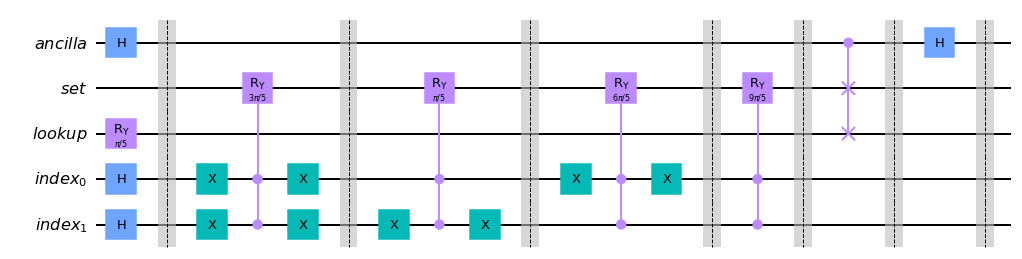

In [26]:
qc.draw(output= 'mpl')

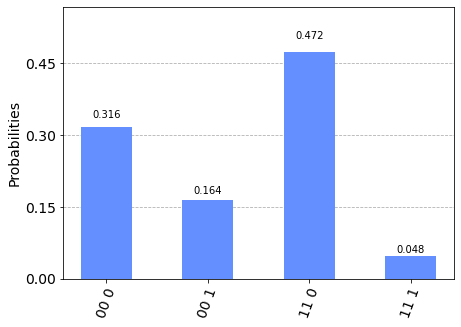

In [30]:
qc_m = qc.copy()
creg_1 = ClassicalRegister(1, name='creg_ancilla')
creg_2 = ClassicalRegister(2, name= 'creg_index')
qc_m.add_register(creg_1)
qc_m.add_register(creg_2)
qc_m.measure(ancilla, creg_1 )
qc_m.measure(index, creg_2)
plot_histogram( execute(qc_m, shots= 1000, backend= qsm).result().get_counts())
